In this notebook, the statistics of `sslf`'s ability to detect spectral lines is analysed.

In [1]:
import numpy as np
from scipy import signal

from sslf.sslf import Spectrum

import matplotlib.pyplot as plt
%matplotlib inline

To ensure that we have consistent results, use a seed value of 1000.

In [2]:
np.random.seed(1000)

This function creates a spectrum containing only Gaussian-distributed noise and a *single* Gaussian-profiled spectral line. To avoid complications with spectral lines being at the edges of a spectrum, place a spectral line *only* within the 10-90% range.

In [3]:
def create_spectrum(line_amplitude=5, line_sigma=3, num_channels=1000):
    sp = np.random.normal(size=num_channels)
    low = num_channels // 10
    high = low * 9
    line_pos = round(np.random.uniform(low, high))
    sp += line_amplitude * np.roll(signal.gaussian(num_channels, line_sigma), (num_channels // 2) + line_pos)
    return sp, line_pos

In [4]:
def plot_example_spectrum(line_amplitude=5, line_sigma=3, num_channels=1000):
    example, pos = create_spectrum(line_amplitude, line_sigma, num_channels)
    _, ax = plt.subplots(2)
    ax[0].plot(example)
    ax[0].scatter(pos, example[pos], marker='x', c='r')
    ax[1].plot(example)
    ax[1].scatter(pos, example[pos], marker='x', c='r')
    ax[1].set_xlim(pos-100, pos+100)
    plt.show()

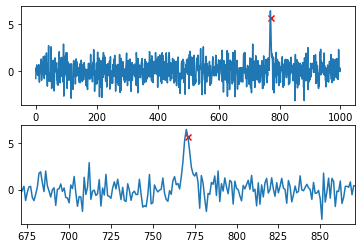

In [5]:
plot_example_spectrum()

`benchmark` plots the histogram of line position errors - that is, the difference between the true position of the spectral line and what `sslf` thinks the position is.

Note that the `snr` parameter refers to the signal-to-noise ratio in the *wavelet* domain, not the original spectrum domain. This makes it difficult to compare with more traditional line finders.

In [6]:
def benchmark(search_scales, trials=10000, plot=True, snr=5, line_amplitude=5, line_sigma=3, num_channels=1000):
    num_lines_found = np.zeros(100)
    peak_offsets = np.zeros(num_channels)

    for _ in range(trials):
        sp, true_line_pos = create_spectrum(line_amplitude, line_sigma, num_channels)
        o = Spectrum(sp)
        o.find_cwt_peaks(search_scales, snr=snr)
        
        # Increment the number of channel peaks in our `lines_found` array.
        num_lines = len(o.channel_peaks)
        num_lines_found[num_lines] += 1

        # If we can, increment the `peak_offsets` array with the closet peak.
        if num_lines > 0:
            closest_peak = np.inf
            for p in o.channel_peaks:
                p2 = abs(p - true_line_pos)
                if p2 < closest_peak:
                    closest_peak = p2
            peak_offsets[closest_peak] += 1
    
    print("Total number of simulated spectra:          {}".format(trials))
    print("    num. of simulations without detections: {}%".format(num_lines_found[0] / trials * 100))
    print("    num. of single detections:              {}%".format(num_lines_found[1] / trials * 100))
    print("    num. of multiple detections:            {}%".format(np.sum(num_lines_found[2:]) / trials * 100))

    for i, p in enumerate(peak_offsets):
        if p > 0:
            smallest_peak_offset = i
            break
    for i, p in enumerate(reversed(peak_offsets)):
        if p > 0:
            largest_peak_offset = len(peak_offsets) - i
            break

    print("Smallest peak channel offset: {} ({}%)".format(smallest_peak_offset, peak_offsets[smallest_peak_offset] / trials * 100))
    print("Largest peak channel offset:  {} ({}%)".format(largest_peak_offset, peak_offsets[largest_peak_offset] / trials * 100))

In [7]:
_ = benchmark(search_scales=np.arange(1, 5))

Total number of simulated spectra:          10000
    num. of simulations without detections: 0.0%
    num. of single detections:              99.56%
    num. of multiple detections:            0.44%
Smallest peak channel offset: 0 (79.45%)
Largest peak channel offset:  3 (0.0%)


We can see that in 99.5% of cases, a single line is detected, and most of the time the channel is exactly right; in about 20% of cases the channel is off by 1 or 2. The remaining 0.44% of cases find at least one false-positive spectral line, but of all lines detected, the one closest to the true line channel has an error no greater than 1. `sslf` always manages to detect a line in these spectra.

The following shows that the wavelet scales used are critical to the performance of `sslf`.

In [8]:
_ = benchmark(search_scales=np.arange(1, 3))

Total number of simulated spectra:          10000
    num. of simulations without detections: 73.69%
    num. of single detections:              26.25%
    num. of multiple detections:            0.06%
Smallest peak channel offset: 0 (15.17%)
Largest peak channel offset:  675 (0.0%)


In [9]:
_ = benchmark(search_scales=np.arange(1, 10))

Total number of simulated spectra:          10000
    num. of simulations without detections: 0.0%
    num. of single detections:              99.35000000000001%
    num. of multiple detections:            0.65%
Smallest peak channel offset: 0 (71.06%)
Largest peak channel offset:  3 (0.0%)


Increasing the search scale range doesn't improve the line finding performance, and will slow down the searching; for these reasons, it is crucial to know your data and select the scales appropriately.

Decreasing the `snr` just finds (a lot) more false positives.

In [10]:
_ = benchmark(search_scales=np.arange(1, 10), snr=3)

Total number of simulated spectra:          10000
    num. of simulations without detections: 0.0%
    num. of single detections:              1.71%
    num. of multiple detections:            98.29%
Smallest peak channel offset: 0 (72.5%)
Largest peak channel offset:  3 (0.0%)


But what if the injected spectral line is very weak?

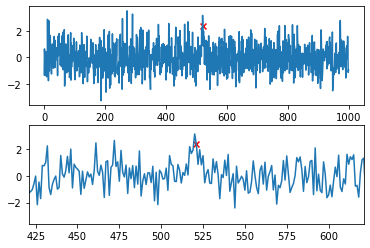

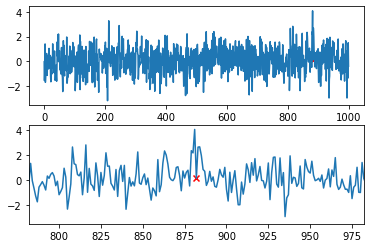

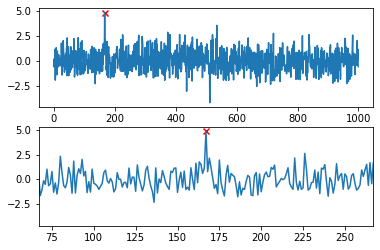

In [11]:
for _ in range(3):
    plot_example_spectrum(line_amplitude=2)

In [12]:
_ = benchmark(search_scales=np.arange(1, 10), snr=5, line_amplitude=2)

Total number of simulated spectra:          10000
    num. of simulations without detections: 65.74%
    num. of single detections:              33.97%
    num. of multiple detections:            0.29%
Smallest peak channel offset: 0 (12.09%)
Largest peak channel offset:  741 (0.0%)


In [13]:
_ = benchmark(search_scales=np.arange(1, 10), snr=4, line_amplitude=2)

Total number of simulated spectra:          10000
    num. of simulations without detections: 23.919999999999998%
    num. of single detections:              60.17%
    num. of multiple detections:            15.909999999999998%
Smallest peak channel offset: 0 (25.540000000000003%)
Largest peak channel offset:  844 (0.0%)


The validity of each of the example spectral lines is very questionable, however, `sslf` still does a good job of identifying them (especially after a little tuning). Line finding is more art than science, so results should always be scrutinised. The more conservative the `snr` value is, the more believable the  results will be. But, these simulations are useful at showing how well `sslf` does "digging in the noise".

Showing the power of the continuous wavelet transform, `sslf` is good at finding weak but wide spectral lines.

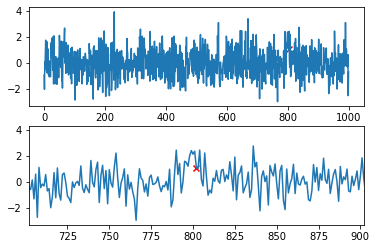

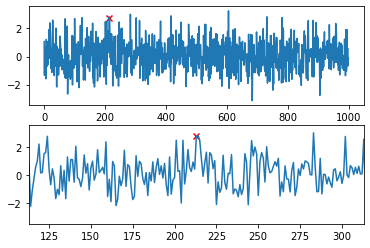

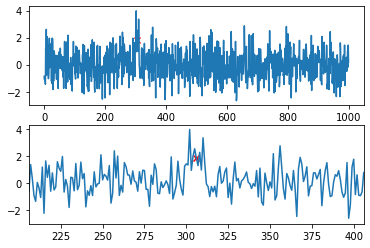

In [14]:
for _ in range(3):
    plot_example_spectrum(line_amplitude=2, line_sigma=5)

In [15]:
_ = benchmark(search_scales=np.arange(1, 10), snr=5, line_amplitude=2, line_sigma=5)

Total number of simulated spectra:          10000
    num. of simulations without detections: 35.88%
    num. of single detections:              63.690000000000005%
    num. of multiple detections:            0.43%
Smallest peak channel offset: 0 (20.31%)
Largest peak channel offset:  830 (0.0%)


The false-positive rate is very small; in this scenario, line detection is "all or nothing". Given that the first two examples shown above would likely be missed by a human, `sslf` does well!